# Importing Modules

In [1]:
%load_ext autotime
import pickle
import string
import warnings
import subprocess
import numpy as np
import regex as re
import pandas as pd
import seaborn as sn
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

import sklearn
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

time: 6.83 s (started: 2022-01-25 15:02:05 +05:30)


In [2]:
warnings.filterwarnings("ignore")
Stopwords = stopwords.words('English')
Stopwords += [i for i in string.ascii_lowercase]

time: 0 ns (started: 2022-01-25 15:02:13 +05:30)


# Defined Functions

## Distribution Table

In [3]:
## Distribution table
def distTab(df, clN=None, bins=None):
    ## When the input is a series or list
    if type(df)==pd.core.series.Series:
        tmpDf = pd.DataFrame(df.value_counts(bins=bins))
        tmpDf = pd.merge(tmpDf,
                         pd.DataFrame(round(df.value_counts(bins=bins, normalize=True)*100,1)),
                         on=tmpDf.index)
        tmpDf.columns = ["Value", "Frequency", "Percentage"]
    ## When the input is a DataFrame or list
    if type(df)==pd.core.frame.DataFrame:
        tmpDf = pd.DataFrame(df[clN].value_counts(bins=bins))
        tmpDf = pd.merge(tmpDf,
                         pd.DataFrame(round(df[clN].value_counts(bins=bins, normalize=True)*100,1)),
                         on=tmpDf.index)
        tmpDf.columns = [clN, "Frequency", "Percentage"]
    else:
        df = pd.Series(df)
        tmpDf = pd.DataFrame(df.value_counts(bins=bins))
        tmpDf = pd.merge(tmpDf,
                         pd.DataFrame(round(df.value_counts(bins=bins, normalize=True)*100,1)),
                         on=tmpDf.index)
        tmpDf.columns = ["Value", "Frequency", "Percentage"]
    return(tmpDf)

time: 0 ns (started: 2022-01-25 15:02:54 +05:30)


## Converting sentences to vec

In [4]:
def sent2vec(s, vec_s, embed):
    words = word_tokenize(s)
    M = []
    for w in words:
        try:
            M.append(embed[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(vec_s)
    return v / np.sqrt((v ** 2).sum())

time: 0 ns (started: 2022-01-25 15:02:54 +05:30)


# Importing Data

In [5]:
con_com = pd.read_csv('complaints.csv')

time: 16.6 s (started: 2022-01-25 15:02:54 +05:30)


# Data Exploration and Preprocessing

## Overall View of the data

In [6]:
con_com.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,18640.0,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,8854.0,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067.0,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2019-08-26,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,33194.0,NaN,NaN,Referral,2019-08-27,Closed with explanation,Yes,NaN,3355681
4,2021-02-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,On XX/XX/2019 my bill did not go through accou...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,32541.0,NaN,Consent provided,Web,2021-02-22,Closed with explanation,Yes,NaN,4157111


time: 32 ms (started: 2022-01-25 15:03:10 +05:30)


Looking at the above snap of the available data:
- Product is the target variable
- Sub-product provides a better understanding of the categories in Product
- Consumer complaint narrative is what we need to classify

We will create a new dataframe with only the required variables

In [7]:
con_com_use = con_com[['Product', 'Sub-product', 'Consumer complaint narrative']]
con_com_use.head()

,Product,Sub-product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,NaN
1,Vehicle loan or lease,Loan,I contacted Ally on Friday XX/XX/XXXX after fa...
2,"Credit reporting, credit repair services, or o...",Credit reporting,NaN
3,Checking or savings account,Checking account,NaN
4,Credit card or prepaid card,General-purpose credit card or charge card,On XX/XX/2019 my bill did not go through accou...


time: 78 ms (started: 2022-01-25 15:03:10 +05:30)


Taking a look at the missing values

## Missing Values

In [8]:
print(con_com_use.shape)
print((pd.isnull(con_com_use).sum()/con_com_use.shape[0])*100)

(2374711, 3)
Product                          0.000000
Sub-product                      9.902847
Consumer complaint narrative    65.089226
dtype: float64
time: 297 ms (started: 2022-01-25 15:03:10 +05:30)


We will have to drop all the missing values in the Consumer complaint narrative

In [9]:
con_com_use = con_com_use[pd.notnull(con_com_use['Consumer complaint narrative'])]

time: 187 ms (started: 2022-01-25 15:03:11 +05:30)


In [10]:
print(con_com_use.shape)
print((pd.isnull(con_com_use).sum()/con_com_use.shape[0])*100)

(829030, 3)
Product                         0.000000
Sub-product                     6.293138
Consumer complaint narrative    0.000000
dtype: float64
time: 125 ms (started: 2022-01-25 15:03:11 +05:30)


## Data distribution

Product


,Product,Frequency,Percentage
0,"Credit reporting, credit repair services, or o...",326828,39.4
1,Debt collection,160799,19.4
2,Mortgage,85766,10.3
3,Credit card or prepaid card,62540,7.5
4,Checking or savings account,38576,4.7
5,Credit reporting,31588,3.8
6,Student loan,29321,3.5
7,"Money transfer, virtual currency, or money ser...",19244,2.3
8,Credit card,18838,2.3
9,Vehicle loan or lease,15521,1.9


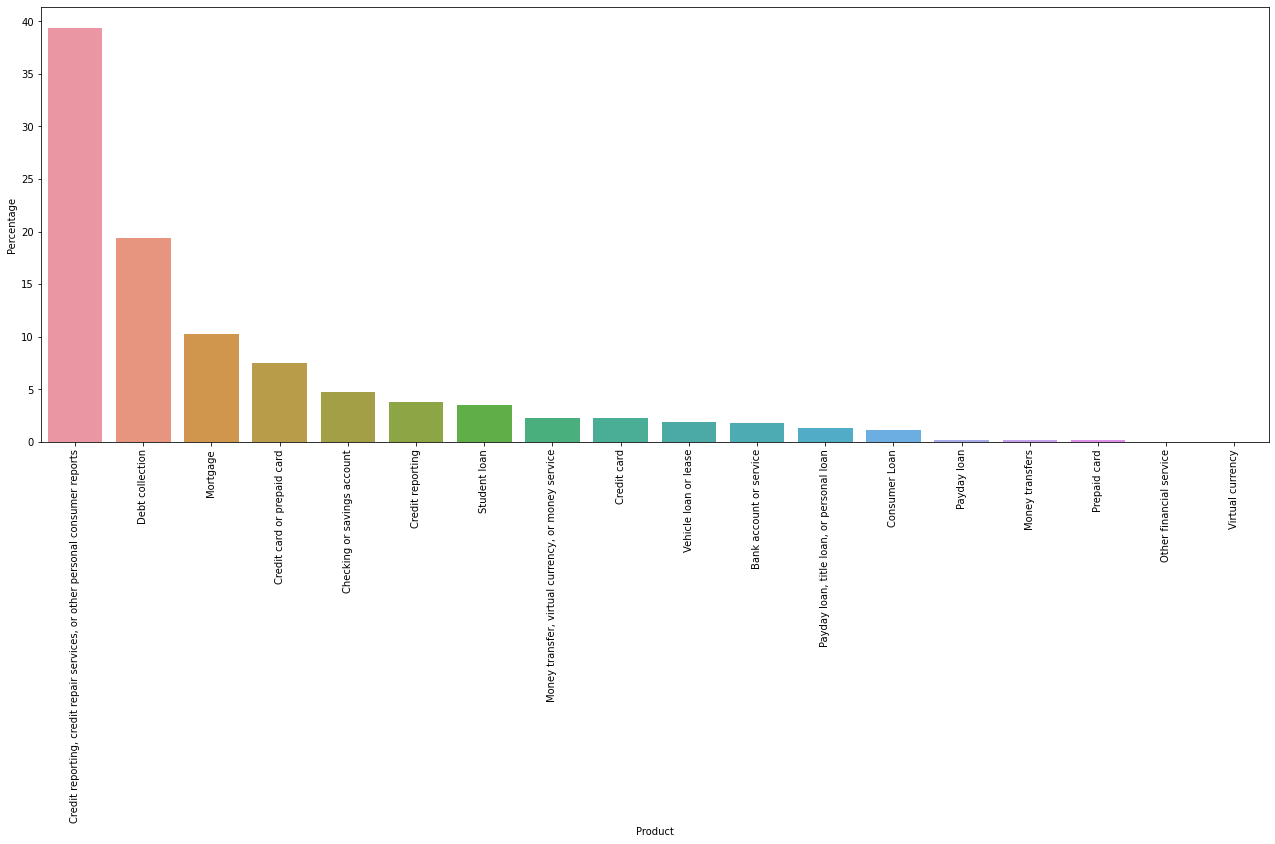




Sub-product


,Sub-product,Frequency,Percentage
0,Credit reporting,321016,41.3
1,General-purpose credit card or charge card,46698,6.0
2,Checking account,41981,5.4
3,Other debt,33618,4.3
4,Conventional home mortgage,32743,4.2
...,...,...,...
70,Credit repair,39,0.0
71,Traveler’s/Cashier’s checks,22,0.0
72,Transit card,19,0.0
73,Student prepaid card,11,0.0


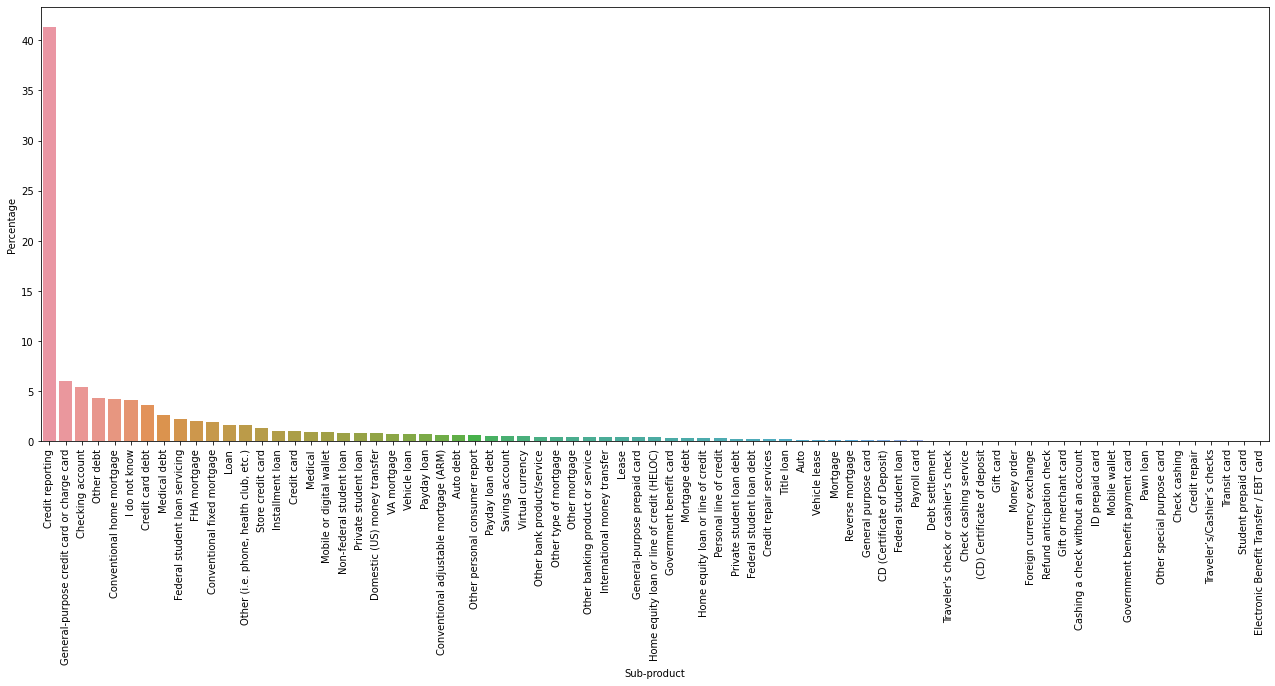




Consumer complaint narrative


,Consumer complaint narrative,Frequency,Percentage
0,There are many mistakes appear in my report wi...,1035,0.1
1,I am a victim of identity theft/fraud. I have ...,842,0.1
2,My credit profile is inaccurate which is not f...,730,0.1
3,ATTN Collections Dept I am submitting a compla...,691,0.1
4,The credit bureaus are reporting inaccurate/ou...,552,0.1
...,...,...,...
744074,Experian has to be the most adverse credit rep...,1,0.0
744075,I cancelled a newspaper subscription back in X...,1,0.0
744076,"XXXX XXXX XXXX XXXX XXXX XXXX, TX XXXX '' Pl...",1,0.0
744077,On XX/XX/XXXX I contacted Enhanced Recovery Co...,1,0.0





time: 3.83 s (started: 2022-01-25 15:03:11 +05:30)


In [11]:
for i in range(len(con_com_use.columns)):
    print(con_com_use.columns[i])
    dist_tmp = distTab(con_com_use, con_com_use.columns[i])
    display(dist_tmp)
    if dist_tmp.shape[0]<=80:
        f, ax = plt.subplots(figsize=(22,8))
        sn.barplot(x=con_com_use.columns[i],y="Percentage",data=dist_tmp)
        plt.xticks(range(len(dist_tmp[con_com_use.columns[i]])), dist_tmp[con_com_use.columns[i]], rotation='vertical')
        plt.show()
    print('\n\n')

Observation from the distribution table:
- We have 18 categories for consumer complaints
- We have a highly imbalanced dataset
- Duplicate categories are present. For example categories such as 'Credit reporting' is present as a combined as well as a seperate category.
- 8,29,030 is the total number of available observations and the unique values present in the Consumer complaint narrative is 7,44,076. Which means there can be duplicates overall.

## Duplicate values

In [12]:
print((sum(con_com_use.duplicated())/con_com_use.shape[0])*100)

10.076233670675368
time: 2.25 s (started: 2022-01-25 15:03:15 +05:30)


10% of the data is duplicate in the data which we have after removal of the missing values.

We will drop all the duplicate values.

In [13]:
con_com_use = con_com_use[~con_com_use.duplicated()]
con_com_use.reset_index(drop=True, inplace=True)
con_com_use.shape

(745495, 3)

time: 2.27 s (started: 2022-01-25 15:03:17 +05:30)


Final observation size is 7,44,722.

Let's take look at the full name of the categories to understand which are the duplicate ones.

## Preprocessing Target Variable

In [14]:
set(con_com_use.Product.tolist())

{'Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Student loan',
 'Vehicle loan or lease',
 'Virtual currency'}

time: 31 ms (started: 2022-01-25 15:03:19 +05:30)


Categories which can be combined:
- 'Credit card' and 'Prepaid card' can be combined with 'Credit card or prepaid card'.
- 'Credit reporting',can be combined with 'Credit reporting, credit repair services, or other personal consumer reports'
- 'Money transfers' and 'Virtual currency' can be combined with 'Money transfer, virtual currency, or money service'
- 'Payday loan' can be combined with 'Payday loan, title loan, or personal loan'




We will try to understand the categories in 'Products' better with a cross tab with the 'Sub-products'.

In [15]:
pd.set_option('display.max_rows', 500) # increase max row view size
display(pd.crosstab(con_com_use['Sub-product'], con_com_use['Product']))
pd.set_option('display.max_rows', 10) # decrease max row view size

Product,Bank account or service,Checking or savings account,Consumer Loan,Credit card or prepaid card,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease,Virtual currency
Sub-product,,,,,,,,,,,,,,,
(CD) Certificate of deposit,273,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Auto,0,0,0,0,0,1041,0,0,0,0,0,0,0,0,0
Auto debt,0,0,0,0,0,4772,0,0,0,0,0,0,0,0,0
CD (Certificate of Deposit),0,579,0,0,0,0,0,0,0,0,0,0,0,0,0
Cashing a check without an account,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Check cashing,0,0,0,0,0,0,0,0,0,53,0,0,0,0,0
Check cashing service,0,0,0,0,0,0,286,0,0,0,0,0,0,0,0
Checking account,10102,31834,0,0,0,0,0,0,0,0,0,0,0,0,0
Conventional adjustable mortgage (ARM),0,0,0,0,0,0,0,0,4972,0,0,0,0,0,0


time: 203 ms (started: 2022-01-25 15:03:19 +05:30)


Understanding overlap between Consumer loan and Vehicle loan

In [16]:
list(set(con_com_use[(con_com_use['Product']=='Consumer Loan') & (con_com_use['Sub-product']=='Vehicle loan')]['Consumer complaint narrative'].tolist()))[:5]

['XXXX XXXX, XXXX XXXX XXXX XXXX XXXX XXXX XXXX. XXXX XXXX XXXX XXXX, TX XXXX XXXX : Loan Number XXXX VIN Number XXXX Dear XXXX XXXX : I am writing to you in hopes that you will be able to assist me with a timely resolution to the on-going problems I am experiencing with Chrysler Capital and XXXX XXXX. \n\n\nI did not receive a statement for XXXX/XXXX/XXXX. It is unclear when the loan was assigned to Chrysler Capital? Please provide me with the date of transfer? Your staff told me that I needed a court order for that information. \nPayment of XXXX/XXXX/XXXX - principal/interest were not applied properly. \nPayment of XXXX/XXXX/XXXX - principal/interest were not applied properly. \nPayment of XXXX/XXXX/XXXX - principal/interest were not applied properly. Payment shows short to correct previous errors. Falsification of reporting to credit agencies. Please correct this immediately. \nPayment of XXXX/XXXX/XXXX - principal/interest were not applied properly. Payment shows short to correct p

time: 94 ms (started: 2022-01-25 15:03:20 +05:30)


Understanding overlap between Consumer loan and Personal line of credit

In [17]:
list(set(con_com_use[(con_com_use['Product']=='Consumer Loan') & (con_com_use['Sub-product']=='Personal line of credit')]['Consumer complaint narrative'].tolist()))[:5]

['Wells Fargo reported a late status on my account on an account that is already paid in full and has no balance',
 "XXXX did not meet their delivery timeline. So I cancelled the order and they continue deduct money from me in XXXX 's when i cancelled XXXX XXXX. They are looking for me to jump through hoops for my refund, while they continues to take money out of my account. I have instructed the bank to place a stop payment for this debit. Called today and they are requesting after two months and no refund to send bank statements to show they have my money and it two month later.",
 "I have been a Paypal and Paypal Credit customer for many years and have never had any problems and have always paid my payments on time. In XXXX 2016 I made a online purchase using Paypal Credit with the agreement that I had 6 months no payments and no interest expiring XXXX XXXX 2016. On or about the XX/XX/2016 I linked my XXXX XXXX XXXX XXXX savings account to my Paypal account ( via Paypal web site ) w

time: 78 ms (started: 2022-01-25 15:03:20 +05:30)


Looking at the above table and filtered Consumer copmplaint narrative, we can:
- Combine 'Other financial service' and 'Money transfer, virtual currency, or money service'
- Combine 'Consumer loan', 'Vehicle loan or lease' and 'Payday loan, title loan, or personal loan'
- Combine 'Bank account or service' and 'Checking or savings account'

- XXXX is used for masking of details

In [18]:
con_com_use['Product'].replace({'Credit card': 'Credit card or prepaid card',
                                'Prepaid card': 'Credit card or prepaid card',
                                'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports',
                                'Money transfers':'Money transfer, virtual currency, or money service',
                                'Virtual currency':'Money transfer, virtual currency, or money service',
                                'Payday loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Other financial service': 'Money transfer, virtual currency, or money service',
                                'Consumer Loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Vehicle loan or lease':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Payday loan, title loan, or personal loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Bank account or service':'Bank account or service, Savings account',
                                'Checking or savings account':'Bank account or service, Savings account'}, inplace=True)

time: 187 ms (started: 2022-01-25 15:03:20 +05:30)


,Product,Frequency,Percentage
0,"Credit reporting, credit repair services, or o...",284166,38.1
1,Debt collection,153541,20.6
2,Mortgage,85663,11.5
3,Credit card or prepaid card,81689,11.0
4,"Bank account or service, Savings account",53407,7.2
5,"Consumer loan, Vehicle loan or lease, Payday l...",37075,5.0
6,Student loan,29189,3.9
7,"Money transfer, virtual currency, or money ser...",20765,2.8


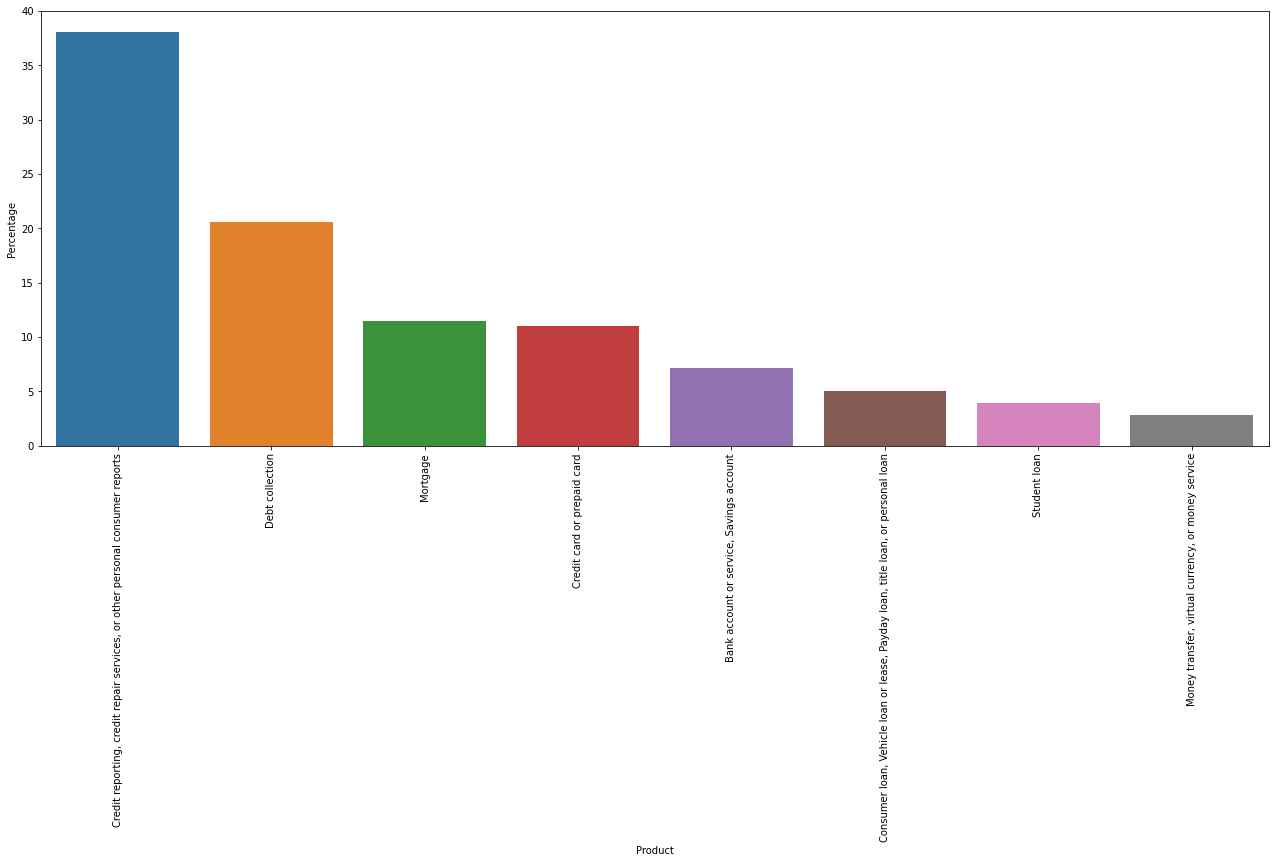

time: 282 ms (started: 2022-01-25 15:03:20 +05:30)


In [19]:
dist_tmp = distTab(con_com_use,'Product')
display(dist_tmp)
f, ax = plt.subplots(figsize=(22,8))
sn.barplot(x='Product',y="Percentage",data=dist_tmp)
plt.xticks(range(len(dist_tmp['Product'])), dist_tmp['Product'], rotation='vertical')
plt.show()

- Number of categories is now 8 but the dataset is still highly imbalanced
- We can drop Sub-product now

In [20]:
con_com_use.drop(['Sub-product'], axis=1, inplace=True)

time: 31 ms (started: 2022-01-25 15:03:20 +05:30)


Sampling for memory constraints

# Preprocessing Text

## Removing punctuations, numbers, masking and converting to lowercase

In [21]:
con_com_use = con_com_use.sample(n=100000)

time: 63 ms (started: 2022-01-25 15:03:20 +05:30)


In [22]:
print('Before')
display(con_com_use['Consumer complaint narrative'])
con_com_use['ConCompLower'] = con_com_use['Consumer complaint narrative'].apply(lambda x: re.sub(r' +', ' ', re.sub(r'x{2,}', ' ', re.sub(r'[^a-z]', ' ', x.lower()))))
print('\n\nAfter')
display(con_com_use['ConCompLower'])

Before


606313    I borrowed XXXX and this company want {$4000.0...
344721    Equifax breach : confirmation that I was affec...
421       I have a public record & Child Support entry t...
56872     XX/XX/19 I tried to make a dispute with Equifa...
354948    I canceled my American Express card in XX/XX/2...
                                ...                        
664910    XXXX XXXX XXXX XXXX XXXX ( AKA ) XXXX XXXX is ...
13290     Since XXXX, XXXX XXXX XXXX has been trying to ...
493982    I have a Macy 's credit card which is serviced...
344882    I notified the company about this been a case ...
490886    There is Public Record Information on my credi...
Name: Consumer complaint narrative, Length: 100000, dtype: object



After


606313    i borrowed and this company want back i blocke...
344721    equifax breach confirmation that i was affecte...
421       i have a public record child support entry tha...
56872      i tried to make a dispute with equifax and it...
354948    i canceled my american express card in with a ...
                                ...                        
664910     aka is inaccurately report a loan as derogato...
13290     since has been trying to say that this debt wa...
493982    i have a macy s credit card which is serviced ...
344882    i notified the company about this been a case ...
490886    there is public record information on my credi...
Name: ConCompLower, Length: 100000, dtype: object

time: 19.4 s (started: 2022-01-25 15:03:20 +05:30)


## Tokenizer

In [23]:
con_com_use['ConCompLowerToken'] = con_com_use['ConCompLower'].apply(word_tokenize)
con_com_use['ConCompLowerToken']

606313    [i, borrowed, and, this, company, want, back, ...
344721    [equifax, breach, confirmation, that, i, was, ...
421       [i, have, a, public, record, child, support, e...
56872     [i, tried, to, make, a, dispute, with, equifax...
354948    [i, canceled, my, american, express, card, in,...
                                ...                        
664910    [aka, is, inaccurately, report, a, loan, as, d...
13290     [since, has, been, trying, to, say, that, this...
493982    [i, have, a, macy, s, credit, card, which, is,...
344882    [i, notified, the, company, about, this, been,...
490886    [there, is, public, record, information, on, m...
Name: ConCompLowerToken, Length: 100000, dtype: object

time: 44.5 s (started: 2022-01-25 15:03:40 +05:30)


## Stopwords

In [24]:
con_com_use['ConCompLowerToken'] = con_com_use['ConCompLowerToken'].apply(lambda x: [i for i in x if i not in Stopwords])
con_com_use['ConCompLemStem'] = con_com_use['ConCompLowerToken']
con_com_use['ConCompLowerStop'] = con_com_use['ConCompLowerToken'].apply(lambda x: ' '.join(x))
con_com_use['ConCompLowerStop']

606313    borrowed company want back blocked account far...
344721    equifax breach confirmation affected breach re...
421       public record child support entry placed credi...
56872     tried make dispute equifax keeps saying call c...
354948    canceled american express card balance however...
                                ...                        
664910    aka inaccurately report loan derogatory paymen...
13290     since trying say debt mine found debt appeared...
493982    macy credit card serviced chase paid balance f...
344882    notified company case identify theft submitted...
490886    public record information credit report inaccu...
Name: ConCompLowerStop, Length: 100000, dtype: object

time: 27.7 s (started: 2022-01-25 15:04:24 +05:30)


## Stemming and Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()
con_com_use['ConCompLemStem'] = con_com_use['ConCompLemStem'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
con_com_use['ConCompLemStem']

606313    [borrowed, company, want, back, blocked, accou...
344721    [equifax, breach, confirmation, affected, brea...
421       [public, record, child, support, entry, placed...
56872     [tried, make, dispute, equifax, keep, saying, ...
354948    [canceled, american, express, card, balance, h...
                                ...                        
664910    [aka, inaccurately, report, loan, derogatory, ...
13290     [since, trying, say, debt, mine, found, debt, ...
493982    [macy, credit, card, serviced, chase, paid, ba...
344882    [notified, company, case, identify, theft, sub...
490886    [public, record, information, credit, report, ...
Name: ConCompLemStem, Length: 100000, dtype: object

time: 32.5 s (started: 2022-01-25 15:04:52 +05:30)


In [26]:
stemmer = PorterStemmer()
con_com_use['ConCompLemStem'] = con_com_use['ConCompLemStem'].apply(lambda x: ' '.join([stemmer.stem(i) for i in x]))
con_com_use['ConCompLemStem']

606313    borrow compani want back block account far pai...
344721    equifax breach confirm affect breach refus pro...
421       public record child support entri place credit...
56872     tri make disput equifax keep say call confirm ...
354948    cancel american express card balanc howev due ...
                                ...                        
664910    aka inaccur report loan derogatori payment pla...
13290     sinc tri say debt mine found debt appear credi...
493982    maci credit card servic chase paid balanc full...
344882    notifi compani case identifi theft submit full...
490886    public record inform credit report inaccur fil...
Name: ConCompLemStem, Length: 100000, dtype: object

time: 2min 53s (started: 2022-01-25 15:05:25 +05:30)


## Encoding Labels

In [27]:
lab_enc = sklearn.preprocessing.LabelEncoder()
y = lab_enc.fit_transform(con_com_use['Product'])

time: 16 ms (started: 2022-01-25 15:08:18 +05:30)


# Modeling

## Tf-Idf

### Train-test split

In [107]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(con_com_use.ConCompLemStem, y,  # Using text stopwords removed and with stemming and lemmatization done
                                                                        stratify=y,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 94 ms (started: 2021-12-16 12:18:38 +05:30)


In [108]:
print (xtrain.shape)
print (xtest.shape)

(70000,)
(30000,)
time: 0 ns (started: 2021-12-16 12:18:38 +05:30)


### Tf-Idf Vectorizer

In [109]:
tfidf_vect = TfidfVectorizer(min_df=2,
                             analyzer='word',
                             ngram_range=(1, 4))

tfidf_vect.fit(list(xtrain) + list(xtest))
xtrain_tfidfv =  tfidf_vect.transform(xtrain)
xtest_tfidfv = tfidf_vect.transform(xtest)

time: 1min 22s (started: 2021-12-16 12:18:38 +05:30)


### Testing base models

In [116]:
clf = [KNeighborsClassifier(n_jobs=20),
       xgb.XGBClassifier(use_label_encoder=False),
       LinearSVC(),
       MultinomialNB()]

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']

models_initial = pd.DataFrame({
    'Model'       : [],
    'Accuracy'    : [],
    'Precision'   : [],
    'Recall'      : [],
    'F1_score'    : []
    })

for model in clf:
    scores = cross_validate(model, xtrain_tfidfv, ytrain, scoring=scoring, cv=5)
    sorted(scores.keys())
    models_initial = pd.concat([models_initial,
                               pd.DataFrame({
                                   'Model'       : [model.__class__.__name__],
                                   'Accuracy'    : [scores['test_accuracy'].mean()],
                                   'Precision'   : [scores['test_precision_macro'].mean()],
                                   'Recall'      : [scores['test_recall_macro'].mean()],
                                   'F1_score'    : [scores['test_f1_weighted'].mean()]
                               })], axis=0)
    print('completed %s ' %(model.__class__.__name__))

models_initial_tfidf = models_initial

completed KNeighborsClassifier 
[12:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:49:06] WARNING: C:/Users/Admini

In [117]:
models_initial_tfidf

,Model,Accuracy,Precision,Recall,F1_score
0,KNeighborsClassifier,0.390129,0.527817,0.135066,0.239774
0,XGBClassifier,0.823357,0.806474,0.771802,0.822017
0,LinearSVC,0.836929,0.825711,0.784240,0.835166
0,MultinomialNB,0.574600,0.754210,0.298828,0.511885


time: 0 ns (started: 2021-12-16 13:03:53 +05:30)


Conclusions:
- We are considering F1_score as the metric because the data is highly imbalanced.
- XGBoost and LinearSVC are the best performing models

## Word2Vec

### Train-test split

In [118]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(con_com_use.ConCompLower, y,
                                                                        stratify=y,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 312 ms (started: 2021-12-16 13:04:58 +05:30)


In [119]:
print (xtrain.shape)
print (xtest.shape)

(70000,)
(30000,)
time: 0 ns (started: 2021-12-16 13:04:58 +05:30)


### Training a Word2Vec model

In [120]:
vectorSize=300
word2vecModel = Word2Vec(con_com_use.ConCompLowerToken.tolist(), min_count=2, vector_size=vectorSize,
                         workers=12, window=5, sg=1,
                         epochs=20)
gensim_embbed = dict(zip(word2vecModel.wv.index_to_key, word2vecModel.wv.vectors))

time: 3min 41s (started: 2021-12-16 13:04:58 +05:30)


Converting training and testing text data to vectors

In [121]:
xtrain_glove = np.array([sent2vec(x, vectorSize, gensim_embbed) for x in tqdm(xtrain)])
xtest_glove = np.array([sent2vec(x, vectorSize, gensim_embbed) for x in tqdm(xtest)])

  0%|          | 0/70000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

time: 1min 6s (started: 2021-12-16 13:08:40 +05:30)


### Training and evaluating base models

In [122]:
clf = [KNeighborsClassifier(n_jobs=20),
       xgb.XGBClassifier(use_label_encoder=False),
       LinearSVC(),
       MultinomialNB()]

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']

models_initial = pd.DataFrame({
    'Model'       : [],
    'Accuracy'    : [],
    'Precision'   : [],
    'Recall'      : [],
    'F1_score'    : []
    })

for model in clf:
    scores = cross_validate(model, xtrain_glove, ytrain, scoring=scoring, cv=5)
    sorted(scores.keys())
    models_initial = pd.concat([models_initial,
                               pd.DataFrame({
                                   'Model'       : [model.__class__.__name__],
                                   'Accuracy'    : [scores['test_accuracy'].mean()],
                                   'Precision'   : [scores['test_precision_macro'].mean()],
                                   'Recall'      : [scores['test_recall_macro'].mean()],
                                   'F1_score'    : [scores['test_f1_weighted'].mean()]
                               })], axis=0)
    print('completed %s ' %(model.__class__.__name__))

models_initial_Word2vec = models_initial

completed KNeighborsClassifier 
[13:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:19:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:35] WARNING: C:/Users/Admini

In [123]:
models_initial_Word2vec

,Model,Accuracy,Precision,Recall,F1_score
0,KNeighborsClassifier,0.786343,0.759405,0.716225,0.783314
0,XGBClassifier,0.813600,0.800492,0.746601,0.811097
0,LinearSVC,0.815686,0.795997,0.766858,0.813602
0,MultinomialNB,NaN,NaN,NaN,NaN


time: 0 ns (started: 2021-12-16 13:48:44 +05:30)


Conclusions:
- We are considering F1_score as the metric because the data is highly imbalanced.
- XGBoost and LinearSVC are the best performing models

## Conclusion Tf-Idf VS Word2Vec

In [348]:
display(models_initial_tfidf)
display(models_initial_Word2vec)

,Model,Accuracy,Precision,Recall,F1_score
0,KNeighborsClassifier,0.390129,0.527817,0.135066,0.239774
0,XGBClassifier,0.823357,0.806474,0.771802,0.822017
0,LinearSVC,0.836929,0.825711,0.784240,0.835166
0,MultinomialNB,0.574600,0.754210,0.298828,0.511885


,Model,Accuracy,Precision,Recall,F1_score
0,KNeighborsClassifier,0.786343,0.759405,0.716225,0.783314
0,XGBClassifier,0.813600,0.800492,0.746601,0.811097
0,LinearSVC,0.815686,0.795997,0.766858,0.813602
0,MultinomialNB,NaN,NaN,NaN,NaN


time: 32 ms (started: 2021-12-16 16:33:07 +05:30)


- Tf-Idf vectorizer outperforms Word2Vec vectorizer on a sample of 100000 sample.
- XGBoost and LinearSVC are the 2 best performing base models.
- Hyperparamater tuning of XGBoost and LinearSVC will decide which model to go forward with.

## Hyperparameter Tuning

### LivearSVC

#### Train-test split

In [305]:
tmp_df = con_com_use.sample(n=5000) # Tuning on 5000 sample 
lab_enc_samp = sklearn.preprocessing.LabelEncoder()
y_samp = lab_enc_samp.fit_transform(tmp_df['Product'])

xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tmp_df.ConCompLemStem, y_samp,  # Using text stopwords removed and with stemming and lemmatization done
                                                                        stratify=y_samp,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 16 ms (started: 2021-12-16 15:09:13 +05:30)


In [306]:
print (xtrain.shape)
print (xtest.shape)

(3500,)
(1500,)
time: 0 ns (started: 2021-12-16 15:09:15 +05:30)


#### Tf-Idf Vectorizer

In [307]:
tfidf_vect = TfidfVectorizer(min_df=2,
                             analyzer='word',
                             ngram_range=(1, 4))

tfidf_vect.fit(list(xtrain) + list(xtest))
xtrain_tfidfv =  tfidf_vect.transform(xtrain)
xtest_tfidfv = tfidf_vect.transform(xtest)

time: 3.66 s (started: 2021-12-16 15:09:20 +05:30)


#### Grid Search

In [322]:
folds = 5

linearSvc_model = LinearSVC()

params = {'C': [0.1,0.5,0.8,0.9,1,1.5,2,2.5],
              'dual': (True, False)
             }
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']

skf = sklearn.model_selection.StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
linearSVC = sklearn.model_selection.GridSearchCV(linearSvc_model, param_grid=params, scoring=scoring, refit='f1_weighted',
                                                 cv=skf.split(xtrain_tfidfv,ytrain), verbose=3)

linearSVC.fit(xtrain_tfidfv,ytrain)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.1, dual=True; accuracy: (test=0.739) f1_weighted: (test=0.723) precision_macro: (test=0.832) recall_macro: (test=0.592) total time=   0.0s
[CV 2/5] END C=0.1, dual=True; accuracy: (test=0.749) f1_weighted: (test=0.737) precision_macro: (test=0.835) recall_macro: (test=0.623) total time=   0.0s
[CV 3/5] END C=0.1, dual=True; accuracy: (test=0.767) f1_weighted: (test=0.751) precision_macro: (test=0.807) recall_macro: (test=0.634) total time=   0.0s
[CV 4/5] END C=0.1, dual=True; accuracy: (test=0.739) f1_weighted: (test=0.719) precision_macro: (test=0.813) recall_macro: (test=0.583) total time=   0.0s
[CV 5/5] END C=0.1, dual=True; accuracy: (test=0.766) f1_weighted: (test=0.747) precision_macro: (test=0.822) recall_macro: (test=0.610) total time=   0.0s
[CV 1/5] END C=0.1, dual=False; accuracy: (test=0.739) f1_weighted: (test=0.723) precision_macro: (test=0.832) recall_macro: (test=0.592) total time=   0.2s
[C

In [323]:
print(linearSVC.best_params_)

{'C': 1.5, 'dual': True}
time: 0 ns (started: 2021-12-16 15:18:46 +05:30)


#### Fitting model on best params

##### Train-test split

In [334]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(con_com_use.ConCompLemStem, y,  # Using text stopwords removed and with stemming and lemmatization done
                                                                        stratify=y,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 47 ms (started: 2021-12-16 15:46:12 +05:30)


In [335]:
print (xtrain.shape)
print (xtest.shape)

(70000,)
(30000,)
time: 0 ns (started: 2021-12-16 15:46:12 +05:30)


##### Tf-Idf Vectorizer

In [336]:
tfidf_vect = TfidfVectorizer(min_df=2,
                             analyzer='word',
                             ngram_range=(1, 4))

tfidf_vect.fit(list(xtrain) + list(xtest))
xtrain_tfidfv =  tfidf_vect.transform(xtrain)
xtest_tfidfv = tfidf_vect.transform(xtest)

time: 1min 19s (started: 2021-12-16 15:46:12 +05:30)


##### Fitting Model

In [338]:
linearSvc_model = LinearSVC(C=1.5, dual=True)
linearSvc_model.fit(xtrain_tfidfv, ytrain)

LinearSVC(C=1.5)

time: 18.1 s (started: 2021-12-16 15:48:07 +05:30)


##### Evaluation

In [342]:
ypred = linearSvc_model.predict(xtest_tfidfv)
print(metrics.classification_report(ytest, ypred, target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

   Credit reporting, credit repair services, or other personal consumer reports       0.79      0.81      0.80      2149
                                       Bank account or service, Savings account       0.74      0.60      0.66      1514
                             Money transfer, virtual currency, or money service       0.78      0.81      0.79      3325
                                                                       Mortgage       0.86      0.88      0.87     11369
                                                                Debt collection       0.81      0.80      0.81      6206
Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan       0.83      0.67      0.75       822
                                                                   Student loan       0.90      0.92      0.91      3428
                               

### XGB

#### Train-test split

In [305]:
tmp_df = con_com_use.sample(n=5000) # Tuning on 5000 sample 
lab_enc_samp = sklearn.preprocessing.LabelEncoder()
y_samp = lab_enc_samp.fit_transform(tmp_df['Product'])

xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tmp_df.ConCompLemStem, y_samp,  # Using text stopwords removed and with stemming and lemmatization done
                                                                        stratify=y_samp,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 16 ms (started: 2021-12-16 15:09:13 +05:30)


In [306]:
print (xtrain.shape)
print (xtest.shape)

(3500,)
(1500,)
time: 0 ns (started: 2021-12-16 15:09:15 +05:30)


#### Tf-Idf Vectorizer

In [307]:
tfidf_vect = TfidfVectorizer(min_df=2,
                             analyzer='word',
                             ngram_range=(1, 4))

tfidf_vect.fit(list(xtrain) + list(xtest))
xtrain_tfidfv =  tfidf_vect.transform(xtrain)
xtest_tfidfv = tfidf_vect.transform(xtest)

time: 3.66 s (started: 2021-12-16 15:09:20 +05:30)


#### Grid Search

In [ ]:
folds = 2

xgb_model = xgb.XGBClassifier(objective='multi:softprob', gamma=0.5, eval_metric='mlogloss', n_estimators=500)
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']

params = {'min_child_weight': [1, 2],
          'subsample': [0.8, 1.0],
          'learning_rate': [0.01, 0.001]
         }

skf = sklearn.model_selection.StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid_search = sklearn.model_selection.GridSearchCV(xgb_model, param_grid=params, scoring=scoring, refit='f1_weighted',
                                                   cv=skf.split(xtrain_tfidfv,ytrain), verbose=3)

grid_search.fit(xtrain_tfidfv, ytrain)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END learning_rate=0.01, min_child_weight=1, subsample=0.8; accuracy: (test=0.758) f1_weighted: (test=0.751) precision_macro: (test=0.751) recall_macro: (test=0.658) total time=  52.1s
[CV 2/2] END learning_rate=0.01, min_child_weight=1, subsample=0.8; accuracy: (test=0.751) f1_weighted: (test=0.746) precision_macro: (test=0.730) recall_macro: (test=0.637) total time=  59.0s
[CV 1/2] END learning_rate=0.01, min_child_weight=1, subsample=1.0; accuracy: (test=0.752) f1_weighted: (test=0.746) precision_macro: (test=0.726) recall_macro: (test=0.654) total time= 1.0min
[CV 2/2] END learning_rate=0.01, min_child_weight=1, subsample=1.0; accuracy: (test=0.742) f1_weighted: (test=0.737) precision_macro: (test=0.703) recall_macro: (test=0.623) total time=  55.6s
[CV 1/2] END learning_rate=0.01, min_child_weight=2, subsample=0.8; accuracy: (test=0.759) f1_weighted: (test=0.754) precision_macro: (test=0.753) recall_macro: (test=0

In [330]:
print(grid_search.best_params_)

{'learning_rate': 0.01, 'min_child_weight': 2, 'subsample': 0.8}
time: 0 ns (started: 2021-12-16 15:42:23 +05:30)


#### Fitting model on best params

##### Train-test split

In [343]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(con_com_use.ConCompLemStem, y,  # Using text stopwords removed and with stemming and lemmatization done
                                                                        stratify=y,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 47 ms (started: 2021-12-16 15:51:43 +05:30)


In [344]:
print (xtrain.shape)
print (xtest.shape)

(70000,)
(30000,)
time: 0 ns (started: 2021-12-16 15:51:45 +05:30)


##### Tf-Idf Vectorizer

In [345]:
tfidf_vect = TfidfVectorizer(min_df=2,
                             analyzer='word',
                             ngram_range=(1, 4))

tfidf_vect.fit(list(xtrain) + list(xtest))
xtrain_tfidfv =  tfidf_vect.transform(xtrain)
xtest_tfidfv = tfidf_vect.transform(xtest)

time: 1min 20s (started: 2021-12-16 15:51:53 +05:30)


##### Fitting Model

In [346]:
xgb_model = xgb_model = xgb.XGBClassifier(objective='multi:softprob', gamma=0.5, eval_metric='mlogloss', n_estimators=500, learning_rate=0.01, min_child_weight=2, subsample=0.8)
xgb_model.fit(xtrain_tfidfv, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

time: 38min 48s (started: 2021-12-16 15:54:16 +05:30)


##### Evaluation

In [347]:
ypred = xgb_model.predict(xtest_tfidfv)
print(metrics.classification_report(ytest, ypred, target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

   Credit reporting, credit repair services, or other personal consumer reports       0.75      0.76      0.75      2149
                                       Bank account or service, Savings account       0.66      0.58      0.62      1514
                             Money transfer, virtual currency, or money service       0.77      0.74      0.76      3325
                                                                       Mortgage       0.81      0.87      0.84     11369
                                                                Debt collection       0.78      0.77      0.77      6206
Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan       0.81      0.58      0.67       822
                                                                   Student loan       0.89      0.87      0.88      3428
                               

### Conclusion LinearSVM vs XGBoost

- Final F1 weighted score for LinearSVC is .83
- Final F1 weighted score for XGBoost is .80
- LinearSVM is performing better than XGBoost

## Deep Learning

### Train-test split

In [32]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(con_com_use.ConCompLemStem, y,
                                                                        stratify=y,
                                                                        random_state=42,
                                                                        test_size=0.3, shuffle=True)

time: 47 ms (started: 2021-12-16 18:54:03 +05:30)


In [33]:
print (xtrain.shape)
print (xtest.shape)

(70000,)
(30000,)
time: 0 ns (started: 2021-12-16 18:54:03 +05:30)


### Training a Word2Vec model

In [34]:
vectorSize=160
word2vecModel = Word2Vec(con_com_use.ConCompLemStem.str.split(' ').tolist(), min_count=2, vector_size=vectorSize,
                         workers=12, window=7, sg=1,
                         epochs=50)
gensim_embbed = dict(zip(word2vecModel.wv.index_to_key, word2vecModel.wv.vectors))

time: 8min 18s (started: 2021-12-16 18:54:03 +05:30)


### Converting target variable to categorial

In [35]:
ytrain_enc = to_categorical(ytrain)
ytest_enc = to_categorical(ytest)

time: 0 ns (started: 2021-12-16 19:02:22 +05:30)


In [36]:
token = preprocessing.text.Tokenizer(num_words=None)
max_len = 140

token.fit_on_texts(list(xtrain) + list(xtest))
xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)

xtrain_pad = preprocessing.sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = preprocessing.sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

time: 10.7 s (started: 2021-12-16 19:02:22 +05:30)


In [37]:
embedding_matrix = np.zeros((len(word_index) + 1, vectorSize))
for word, i in tqdm(word_index.items()):
    embedding_vector = gensim_embbed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/35227 [00:00<?, ?it/s]

time: 62 ms (started: 2021-12-16 19:02:32 +05:30)


### Bi-Directional LSTM

#### Model Iterations

In [53]:
model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           vectorSize,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(1024, dropout=0.2)))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(8))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 400)           14113200  
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 50, 400)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 2048)              11673600  
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)             

In [54]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=1024, epochs=100, verbose=1,
          validation_data=(xtest_pad, ytest_enc), callbacks=[earlystop])

Epoch 1/100
69/69 [==============================] - 70s 984ms/step - loss: 1.6320 - val_loss: 1.1963
Epoch 2/100
69/69 [==============================] - 79s 1s/step - loss: 1.2524 - val_loss: 1.1965
Epoch 3/100
69/69 [==============================] - 82s 1s/step - loss: 1.1405 - val_loss: 0.9323
Epoch 4/100
69/69 [==============================] - 83s 1s/step - loss: 0.9759 - val_loss: 0.8380
Epoch 5/100
69/69 [==============================] - 84s 1s/step - loss: 0.8888 - val_loss: 0.7826
Epoch 6/100
69/69 [==============================] - 84s 1s/step - loss: 0.8230 - val_loss: 0.7675
Epoch 7/100
69/69 [==============================] - 84s 1s/step - loss: 0.7949 - val_loss: 0.7067
Epoch 8/100
69/69 [==============================] - 85s 1s/step - loss: 0.7649 - val_loss: 0.6953
Epoch 9/100
69/69 [==============================] - 84s 1s/step - loss: 0.7384 - val_loss: 0.6706
Epoch 10/100
69/69 [==============================] - 86s 1s/step - loss: 0.7082 - val_loss: 0.6656
Epoch 

time: 28min 54s (started: 2021-12-15 19:22:29 +05:30)


In [55]:
ypred = model.predict(xtest_pad)
print(metrics.classification_report(np.argmax(ytest_enc, axis=-1), np.argmax(ypred, axis=-1), 
                                    target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

                                       Bank account or service, Savings account       0.66      0.75      0.70      2144
                                                                       Mortgage       0.60      0.61      0.60      1483
                                                                   Student loan       0.68      0.76      0.72      3298
   Credit reporting, credit repair services, or other personal consumer reports       0.86      0.85      0.86     11448
                             Money transfer, virtual currency, or money service       0.83      0.72      0.77      6212
                                                                Debt collection       0.72      0.63      0.67       835
                                                    Credit card or prepaid card       0.83      0.88      0.86      3426
Consumer loan, Vehicle loan or 

In [85]:
model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           vectorSize,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))

model.add(layers.Bidirectional(layers.LSTM(512, dropout=0.2)))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(8))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 50, 400)           14113200  
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 1024)              3739648   
_________________________________________________________________
dense_87 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_68 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 8)               

In [86]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=1024, epochs=100, verbose=1,
          validation_data=(xtest_pad, ytest_enc), callbacks=[earlystop])

Epoch 1/100
69/69 [==============================] - 29s 376ms/step - loss: 1.4579 - val_loss: 0.7892
Epoch 2/100
69/69 [==============================] - 28s 404ms/step - loss: 0.8374 - val_loss: 0.7106
Epoch 3/100
69/69 [==============================] - 29s 418ms/step - loss: 0.7499 - val_loss: 0.6813
Epoch 4/100
69/69 [==============================] - 29s 418ms/step - loss: 0.7075 - val_loss: 0.6499
Epoch 5/100
69/69 [==============================] - 30s 439ms/step - loss: 0.6690 - val_loss: 0.6636
Epoch 6/100
69/69 [==============================] - 30s 430ms/step - loss: 0.6488 - val_loss: 0.6234
Epoch 7/100
69/69 [==============================] - 30s 429ms/step - loss: 0.6263 - val_loss: 0.6305
Epoch 8/100
69/69 [==============================] - 29s 425ms/step - loss: 0.5965 - val_loss: 0.6048
Epoch 9/100
69/69 [==============================] - 30s 434ms/step - loss: 0.5818 - val_loss: 0.6160
Epoch 10/100
69/69 [==============================] - 30s 437ms/step - loss: 0.556

time: 6min 21s (started: 2021-12-15 21:10:24 +05:30)


In [87]:
ypred = model.predict(xtest_pad)
print(metrics.classification_report(np.argmax(ytest_enc, axis=-1), np.argmax(ypred, axis=-1), 
                                    target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

                                       Bank account or service, Savings account       0.72      0.70      0.71      2144
                                                                       Mortgage       0.65      0.52      0.58      1483
                                                                   Student loan       0.71      0.72      0.71      3298
   Credit reporting, credit repair services, or other personal consumer reports       0.87      0.84      0.85     11448
                             Money transfer, virtual currency, or money service       0.73      0.84      0.78      6212
                                                                Debt collection       0.73      0.67      0.70       835
                                                    Credit card or prepaid card       0.88      0.85      0.86      3426
Consumer loan, Vehicle loan or 

In [88]:
model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           vectorSize,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))

model.add(layers.Bidirectional(layers.LSTM(512, dropout=0.2)))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(8))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 400)           14113200  
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 1024)              3739648   
_________________________________________________________________
dense_90 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_70 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_71 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 8)               

In [89]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=1024, epochs=100, verbose=1,
          validation_data=(xtest_pad, ytest_enc), callbacks=[earlystop])

Epoch 1/100
69/69 [==============================] - 24s 314ms/step - loss: 1.4309 - val_loss: 0.8063
Epoch 2/100
69/69 [==============================] - 23s 339ms/step - loss: 0.8315 - val_loss: 0.7010
Epoch 3/100
69/69 [==============================] - 25s 368ms/step - loss: 0.7459 - val_loss: 0.6988
Epoch 4/100
69/69 [==============================] - 26s 383ms/step - loss: 0.7067 - val_loss: 0.6279
Epoch 5/100
69/69 [==============================] - 27s 386ms/step - loss: 0.6463 - val_loss: 0.6460
Epoch 6/100
69/69 [==============================] - 27s 392ms/step - loss: 0.6358 - val_loss: 0.6196
Epoch 7/100
69/69 [==============================] - 28s 405ms/step - loss: 0.6123 - val_loss: 0.6081
Epoch 8/100
69/69 [==============================] - 28s 403ms/step - loss: 0.5927 - val_loss: 0.6114
Epoch 9/100
69/69 [==============================] - 29s 422ms/step - loss: 0.5669 - val_loss: 0.6059
Epoch 10/100
69/69 [==============================] - 28s 402ms/step - loss: 0.551

time: 6min 40s (started: 2021-12-16 11:45:03 +05:30)


In [90]:
ypred = model.predict(xtest_pad)
print(metrics.classification_report(np.argmax(ytest_enc, axis=-1), np.argmax(ypred, axis=-1), 
                                    target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

                                       Bank account or service, Savings account       0.63      0.78      0.70      2144
                                                                       Mortgage       0.69      0.51      0.58      1483
                                                                   Student loan       0.73      0.68      0.71      3298
   Credit reporting, credit repair services, or other personal consumer reports       0.87      0.85      0.86     11448
                             Money transfer, virtual currency, or money service       0.77      0.80      0.78      6212
                                                                Debt collection       0.72      0.65      0.68       835
                                                    Credit card or prepaid card       0.85      0.87      0.86      3426
Consumer loan, Vehicle loan or 

#### Final model

In [38]:
modelLSTM = Sequential()
modelLSTM.add(layers.Embedding(len(word_index)+1,
                               vectorSize,
                               weights=[embedding_matrix],
                               input_length=max_len,
                               trainable=False))

modelLSTM.add(layers.Bidirectional(layers.LSTM(512, dropout=0.2)))

modelLSTM.add(layers.Dense(1024, activation='relu'))
modelLSTM.add(layers.Dropout(0.8))

modelLSTM.add(layers.Dense(1024, activation='relu'))
modelLSTM.add(layers.Dropout(0.8))

modelLSTM.add(layers.Dense(8))
modelLSTM.add(layers.Activation('softmax'))

modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 160)          5636480   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2756608   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 8

In [39]:
modelLSTM.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1,
              validation_data=(xtest_pad, ytest_enc), callbacks=[earlystop])

Epoch 1/100
137/137 [==============================] - 62s 357ms/step - loss: 1.3529 - val_loss: 0.7928
Epoch 2/100
137/137 [==============================] - 54s 392ms/step - loss: 0.8157 - val_loss: 0.6726
Epoch 3/100
137/137 [==============================] - 56s 413ms/step - loss: 0.7060 - val_loss: 0.6217
Epoch 4/100
137/137 [==============================] - 59s 427ms/step - loss: 0.6859 - val_loss: 0.5781
Epoch 5/100
137/137 [==============================] - 60s 441ms/step - loss: 0.6161 - val_loss: 0.5852
Epoch 6/100
137/137 [==============================] - 62s 452ms/step - loss: 0.5925 - val_loss: 0.5462
Epoch 7/100
137/137 [==============================] - 64s 465ms/step - loss: 0.5690 - val_loss: 0.5437
Epoch 8/100
137/137 [==============================] - 65s 471ms/step - loss: 0.5510 - val_loss: 0.5233
Epoch 9/100
137/137 [==============================] - 66s 480ms/step - loss: 0.5330 - val_loss: 0.5234
Epoch 10/100
137/137 [==============================] - 67s 486m

time: 19min 12s (started: 2021-12-16 19:02:41 +05:30)


In [40]:
print(metrics.classification_report(np.argmax(ytest_enc, axis=-1), np.argmax(modelLSTM.predict(xtest_pad), axis=-1), target_names=con_com_use['Product'].unique()))

                                                                                 precision    recall  f1-score   support

   Credit reporting, credit repair services, or other personal consumer reports       0.80      0.72      0.76      2185
                                                    Credit card or prepaid card       0.73      0.58      0.65      1504
                                                                Debt collection       0.71      0.84      0.77      3287
Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan       0.88      0.87      0.87     11413
                                                                       Mortgage       0.82      0.80      0.81      6180
                                                                   Student loan       0.74      0.71      0.73       831
                                       Bank account or service, Savings account       0.87      0.94      0.90      3446
                             Mo

## Conclusion LinearSVM vs Bi-Directional LSTM

- Final F1 weighted score for LinearSVC is .83
- Final F1 weighted score for Bi-Directional LSTM is .83
- We are going forward with the Bi-Directional LSTM model

## Saving models, label encoder and vectorizers

In [67]:
pickle.dump(lab_enc, open('Consumer_complaint_classes.obj', 'wb'))
pickle.dump(token, open('tokenizerTF.obj', 'wb'))
word2vecModel.save("word2vec.model")
modelLSTM.save('LSTM_model.h5')

time: 860 ms (started: 2021-12-16 19:51:48 +05:30)


# Final Function

## Process string

In [1]:
def consumer_complaint_classifier(str_inp, lab_enc_pth, token_pth, clf_model_pth):
    import pickle
    import string
    import sklearn
    import regex as re
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow.keras import preprocessing
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import TfidfVectorizer
    Stopwords = stopwords.words('English')
    Stopwords += [i for i in string.ascii_lowercase]
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    lab_enc_loaded = pickle.load(open(lab_enc_pth, 'rb'))
    token_loaded = pickle.load(open(token_pth, 'rb'))
    clf_model = tf.keras.models.load_model(clf_model_pth)
    str_inp = [i for i in word_tokenize(re.sub(r' +', ' ', re.sub(r'x{2,}', ' ', re.sub(r'[^a-z]', ' ', str_inp.lower())))) if i not in Stopwords]
    str_inp = [lemmatizer.lemmatize(i) for i in str_inp]
    str_inp = [stemmer.stem(i) for i in str_inp]
    str_out = lab_enc_loaded.inverse_transform(np.argmax(clf_model.predict(preprocessing.sequence.pad_sequences(token_loaded.texts_to_sequences([str_inp]), maxlen=140)), axis=-1))
    return str_out[0]

In [2]:
import pandas as pd
con_com = pd.read_csv('complaints.csv')

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
tmp_df = con_com[pd.notnull(con_com['Consumer complaint narrative'])].sample(n=1)[['Product','Consumer complaint narrative']]
tmp_df['Product'].replace({'Credit card': 'Credit card or prepaid card',
                           'Prepaid card': 'Credit card or prepaid card',
                           'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports',
                           'Money transfers':'Money transfer, virtual currency, or money service',
                           'Virtual currency':'Money transfer, virtual currency, or money service',
                           'Payday loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                           'Other financial service': 'Money transfer, virtual currency, or money service',
                           'Consumer Loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                           'Vehicle loan or lease':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                           'Payday loan, title loan, or personal loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                           'Bank account or service':'Bank account or service, Savings account',
                           'Checking or savings account':'Bank account or service, Savings account'}, inplace=True)
display(tmp_df)
tmp_df['Consumer complaint narrative'].tolist()

,Product,Consumer complaint narrative
749989,"Credit reporting, credit repair services, or o...",Habitat for Humanity XXXX XXXX County has lis...


['Habitat for Humanity XXXX  XXXX County has listed my account balance the same since XX/XX/2019. I submitted information and documentation to XXXX to resolve submitted dispute for incorrect payment history, continues to report back verified and accurate. \nHabitat for Humanity XXXX XXXX County, I am requesting statement balance as of close of business date XX/XX/2019 to include my payoff balance. I also am requesting the estimated date that my payment made XX/XX/2019 will be submitted and processed. I also would like a written response as to why I I have to contact the CFPB in order to get responses to written request sent certified mail with no answer.']

In [4]:
consumer_complaint_classifier(str_inp=tmp_df['Consumer complaint narrative'].tolist()[0], lab_enc_pth='Consumer_complaint_classes.obj', token_pth='tokenizerTF.obj', clf_model_pth='LSTM_model.h5')

'Credit reporting, credit repair services, or other personal consumer reports'

## Batch Processing

In [13]:
def consumer_complaint_classifier_batch(dat_pth, lab_enc_pth, token_pth, clf_model_pth):
    import pickle
    import string
    import sklearn
    import regex as re
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow.keras import preprocessing
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import TfidfVectorizer
    Stopwords = stopwords.words('English')
    Stopwords += [i for i in string.ascii_lowercase]
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    dat = pd.read_csv(dat_pth)
    lab_enc_loaded = pickle.load(open(lab_enc_pth, 'rb'))
    token_loaded = pickle.load(open(token_pth, 'rb'))
    clf_model = tf.keras.models.load_model(clf_model_pth)
    dat['Consumer complaint narrative'].fillna('', inplace=True)
    dat['ConComp'] = dat['Consumer complaint narrative'].apply(
        lambda x: re.sub(r' +', ' ', re.sub(r'x{2,}', ' ', re.sub(r'[^a-z]', ' ', x.lower())))).apply(word_tokenize).apply(
        lambda x: [i for i in x if i not in Stopwords]).apply(
        lambda x: [lemmatizer.lemmatize(i) for i in x]).apply(
        lambda x: ' '.join([stemmer.stem(i) for i in x]))
    dat['Product_Pred'] = lab_enc_loaded.inverse_transform(np.argmax(clf_model.predict(preprocessing.sequence.pad_sequences(token_loaded.texts_to_sequences(dat['ConComp']), maxlen=140)), axis=-1))
    dat.drop(['ConComp'], axis=1, inplace=True)
    return dat

In [14]:
# con_com[pd.notnull(con_com['Consumer complaint narrative'])].sample(n=10000).to_csv('ConsumerComplaintSample.csv', index=False)
import sklearn
pred_output = consumer_complaint_classifier_batch(dat_pth='ConsumerComplaintSample.csv', lab_enc_pth='Consumer_complaint_classes.obj', token_pth='tokenizerTF.obj', clf_model_pth='LSTM_model.h5')
pred_output['Product'].replace({'Credit card': 'Credit card or prepaid card',
                                'Prepaid card': 'Credit card or prepaid card',
                                'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports',
                                'Money transfers':'Money transfer, virtual currency, or money service',
                                'Virtual currency':'Money transfer, virtual currency, or money service',
                                'Payday loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Other financial service': 'Money transfer, virtual currency, or money service',
                                'Consumer Loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Vehicle loan or lease':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Payday loan, title loan, or personal loan':'Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan',
                                'Bank account or service':'Bank account or service, Savings account',
                                'Checking or savings account':'Bank account or service, Savings account'}, inplace=True)
print(sklearn.metrics.classification_report(pred_output.Product, pred_output.Product_Pred))

                                                                                 precision    recall  f1-score   support

                                       Bank account or service, Savings account       0.78      0.72      0.75       661
Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan       0.75      0.62      0.67       447
                                                    Credit card or prepaid card       0.71      0.84      0.77       964
   Credit reporting, credit repair services, or other personal consumer reports       0.89      0.88      0.89      4363
                                                                Debt collection       0.80      0.79      0.80      1949
                             Money transfer, virtual currency, or money service       0.73      0.72      0.73       265
                                                                       Mortgage       0.88      0.93      0.90      1021
                               

In [78]:
pred_output.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Product_Pred
0,2016-02-11,Credit card or prepaid card,NaN,Delinquent account,NaN,"XXXX XXXX XXXX XXXX XXXX, CA - XXXX XXXX/XXXX/...",NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,91502,NaN,Consent provided,Web,2016-02-11,Closed with explanation,Yes,Yes,1782738,Credit card or prepaid card
1,2021-09-07,Mortgage,FHA mortgage,Closing on a mortgage,NaN,"On XX/XX/21, I made my last mortgage payment t...",Company has responded to the consumer and the ...,"LAKEVIEW LOAN SERVICING, LLC",CA,92316.0,NaN,Consent provided,Web,2021-09-27,Closed with explanation,Yes,NaN,4698085,Mortgage
2,2018-02-23,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,I have been getting daily calls from the compa...,Company believes it acted appropriately as aut...,"Key 2 Recovery, Inc.",CA,94519.0,NaN,Consent provided,Web,2018-02-23,Closed with explanation,Yes,NaN,2824120,Debt collection
3,2016-10-05,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,"I had problems paying my mortgage, I applied f...",NaN,"Fay Servicing, LLC",TX,77450,NaN,Consent provided,Web,2016-10-05,Closed with explanation,Yes,Yes,2147666,Mortgage
4,2018-06-27,"Consumer loan, Vehicle loan or lease, Payday l...",Installment loan,Charged fees or interest you didn't expect,NaN,I have a loan with service finance company. Th...,Company believes it acted appropriately as aut...,"Service Finance Holdings, LLC",VA,23185.0,Servicemember,Consent provided,Web,2018-07-02,Closed with explanation,Yes,NaN,2947580,"Consumer loan, Vehicle loan or lease, Payday l..."


time: 15 ms (started: 2021-12-16 20:31:47 +05:30)


# End of Notebook